## Introduction:
Video games generate a lot of information about how players behave. The UBC Computer Science research group led by Frank Wood is running a special Minecraft research server to study these behaviours. Every time a player joins the server, their actions and play sessions are recorded. In this project, we wants to use this data to understand players better and also to improve how they can run the server in a more efficient way.

Our project focuses on the question:
* Which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts. 

This question is very meaningful because players who play longer create more data, which is helpful for the research group. If we can predict which players will have longer playtime, the team can focus their efforts on those types of players and generate more useful data.

To answer this question, we used the dataset: players.csv

The players dataset contains 196 unique players. Each row represents one player and includes their basic information and their overall gameplay history. The dataset has 7 variables: 

* experience (categorical): How familiar the player is with Minecraft (“Beginner”, “Intermediate”, “Expert”, "Pro", "Regular").

* subscribe (TRUE/FALSE): Whether the player signed up for the game-related newsletter.

* hashedEmail (string): An ID for each player.

* played_hours (numeric): The total number of hours the player has spent on the server across all sessions.

* name (string): Players' usernames.

* gender (categorical): Player’s gender.

* Age (numeric, mostly complete): Player’s age in years.(2 missing values)

In this report, we will show how we tidied and wrangled the data, built and choose our model, and analyzed the results to understand what types of players tend to play more on the server.

In [20]:
#loading the library
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(ggplot2)
library(RColorBrewer)

In [21]:
players_data <- read_csv("players.csv", 
                         col_names=TRUE)

head(players_data)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


In [22]:
#tidy data
players_tidy <- players_data |> 

# Select out the hashedEmail and name column vectors as they are identifiers and contain no predictive information.
                select(-hashedEmail, -name) |> 

#Convert subscribe, experience, and gender character variables to factor variables so that R can treat them as categorical variables.
  mutate(subscribe_fct=as_factor(subscribe)) |> 
  mutate(experience_fct=as_factor(experience)) |>
  mutate(gender_fct=as_factor(gender)) |>

#Filter out the played_hours variable and select only those who have >0 gameplay hours. Zero-hour players are non-contributors and do not contribute to the goal of identifying high-engagement users.
                filter(played_hours>0) |> 

#Remove rows with missing Age, as leaving NA values leads to loss of rows silently and inconsistencies in model prediction.
         filter(!is.na(Age)) |>   

#To deal with extreme outliers in played_hours, transform highly skewed values into log as it compresses the large values, which makes the distribution closer to normal and stabilizes variance. 
         mutate(played_hours_log = log(played_hours + 1))
               

#remove non fct columns to prevent multicollinearlity when performing multivariable linear regression and to ease visualisation of the dataset.

players_clean<- players_tidy |> drop_na(played_hours_log, experience_fct, gender_fct, Age) |> select(experience_fct, subscribe_fct, gender_fct, Age, played_hours_log)

head(players_clean)

experience_fct,subscribe_fct,gender_fct,Age,played_hours_log
<fct>,<fct>,<fct>,<dbl>,<dbl>
Pro,TRUE,Male,9,3.44361810
Veteran,TRUE,Male,17,1.56861592
Amateur,TRUE,Female,21,0.53062825
Regular,TRUE,Male,21,0.09531018
Amateur,TRUE,Male,47,0.09531018
Veteran,TRUE,Female,23,0.95551145


experience_fct,total_hours
<fct>,<dbl>
Pro,7.590369
Veteran,13.301916
Amateur,36.530174
Regular,27.261411
Beginner,14.002397


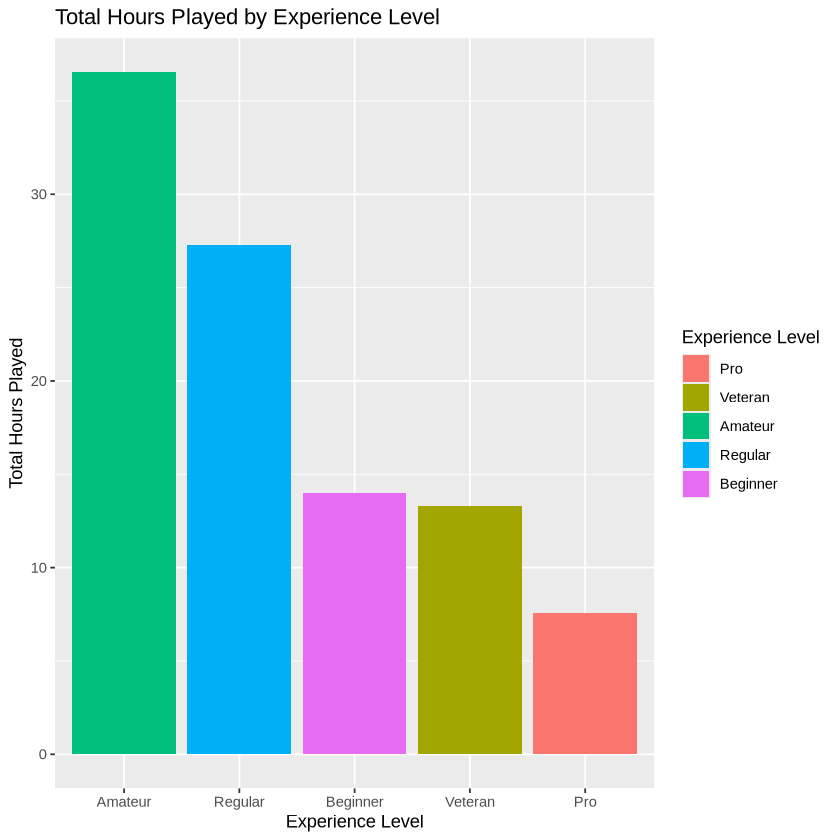

In [23]:
bar_plot_tidy_players <- players_clean |>
  group_by(experience_fct) |>
  summarise(total_hours = sum(played_hours_log), .groups = "drop")
bar_plot_tidy_players

bar_plot_experience_vs_totalhrs <- bar_plot_tidy_players |> 
  ggplot(aes(x = fct_reorder(experience_fct, total_hours, .desc=TRUE),
             y = total_hours,
             fill = experience_fct)) +
  geom_bar(stat = "identity") +
  labs(x = "Experience Level", 
       y = "Total Hours Played", 
       fill = "Experience Level",title = "Total Hours Played by Experience Level")

bar_plot_experience_vs_totalhrs

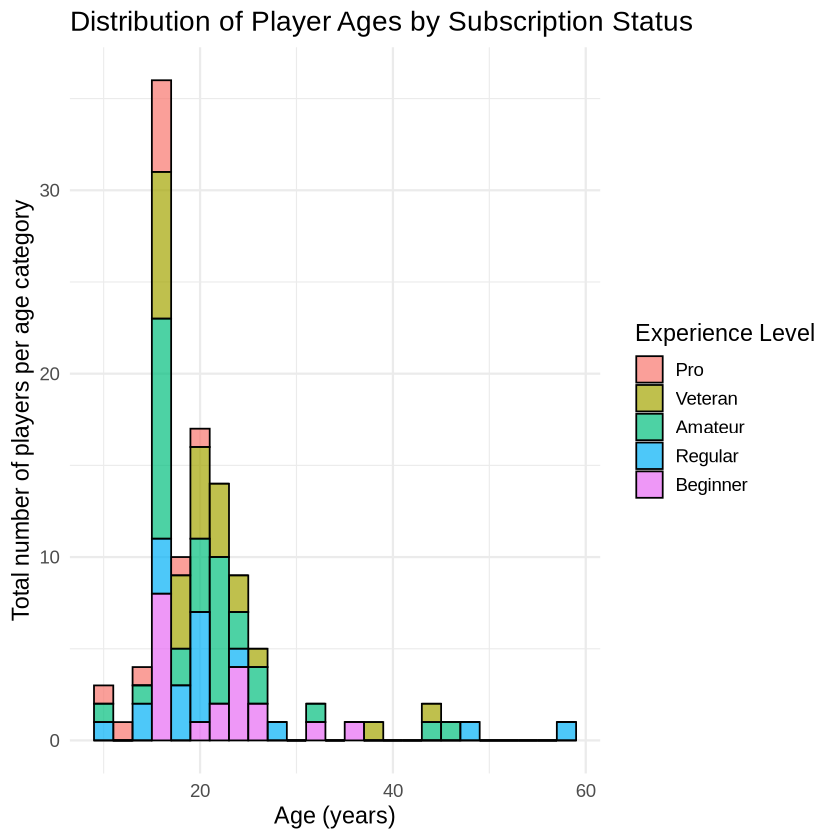

In [24]:
players_age_hours_hist <- players_clean |> 
   ggplot(aes(x = Age, fill = experience_fct)) +
  geom_histogram(binwidth = 2,color="black", alpha=0.7) +
  labs(
    title = "Distribution of Player Ages by Subscription Status",
    x = "Age (years)",
    y = "Total number of players per age category",
    fill = "Experience Level"
  ) +
  theme_minimal(base_size = 14) 
  
players_age_hours_hist

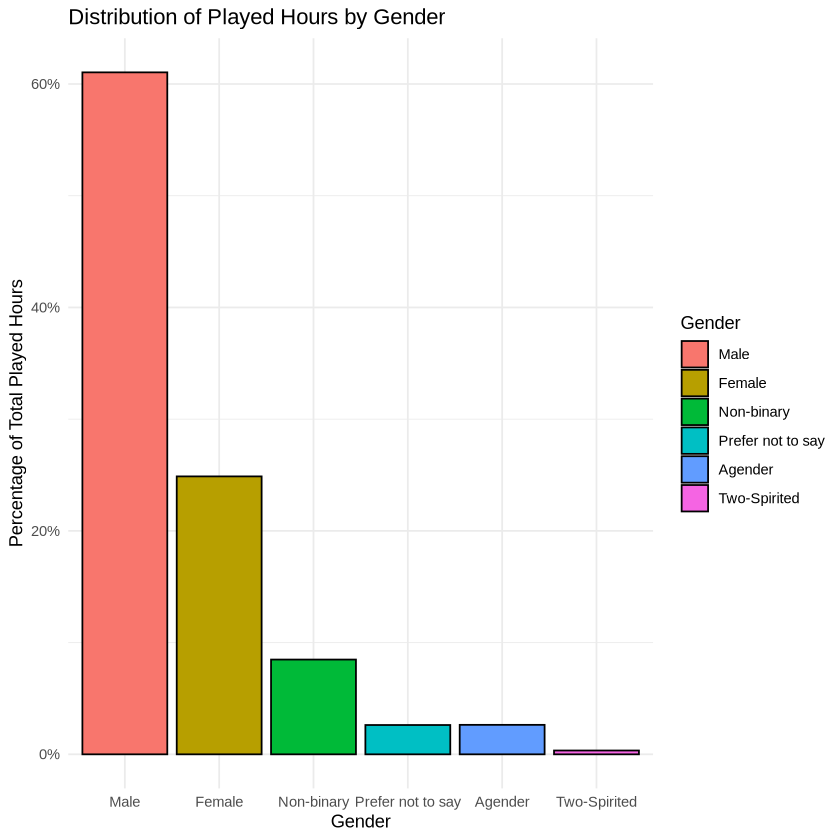

In [25]:
 plot_data <- players_clean |>
  group_by(gender_fct) |> 
  summarise(total_hours = sum(played_hours_log), .groups = "drop") |>
  mutate(percentage = total_hours / sum(total_hours))

experience_gender_percent_plot_fct <- ggplot(plot_data,
                                             aes(x = gender_fct,
                                                 y = percentage, fill=gender_fct)) +
  geom_bar(stat = "identity", colour = "black") +
  scale_y_continuous(labels = scales::percent_format()) +
  labs(
    x = "Gender",
    y = "Percentage of Total Played Hours",
    title = "Distribution of Played Hours by Gender",
  fill="Gender") +
  theme_minimal()

experience_gender_percent_plot_fct


### Making a prediction model

#### Predicting played hours based on experience level, age, and gender

In [26]:
options(repr.matrix.max.rows = 6)
players_clean

experience_fct,subscribe_fct,gender_fct,Age,played_hours_log
<fct>,<fct>,<fct>,<dbl>,<dbl>
Pro,TRUE,Male,9,3.4436181
Veteran,TRUE,Male,17,1.5686159
Amateur,TRUE,Female,21,0.5306283
⋮,⋮,⋮,⋮,⋮
Veteran,TRUE,Female,44,0.09531018
Veteran,FALSE,Male,22,0.26236426
Amateur,FALSE,Male,17,1.19392247


#### 1. Attempting a KNN regression model

In [27]:
#setting the seed
set.seed(1234)

#splitting the data into a training and testing set; a 75% proportion ratio will be used for the training data
players_split <- initial_split(players_clean, prop = 0.75, strata = played_hours_log)
players_training <- training(players_split)
players_testing <- testing(players_split)

In [28]:
#make a recipe for preprocessing the data; scale and center the data
players_recipe <- recipe(played_hours_log ~ experience_fct + Age + gender_fct, data = players_training) |>
    step_dummy(all_nominal_predictors()) |>
    step_zv(all_predictors()) |>
    step_scale(all_numeric_predictors()) |>
    step_center(all_numeric_predictors())

#make a knn model, where the best k value is found
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

#conduct cross validation where there are 5 folds
players_vfold <- vfold_cv(players_training, v = 5, strata = played_hours_log)

#create a workflow
players_wkflw <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec)
players_wkflw

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
4 Recipe Steps

• step_dummy()
• step_zv()
• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [29]:
#run cross validation and determine the best k value for the training data set
gridvals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))
players_results <- players_wkflw |>
    tune_grid(resamples = players_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")
k_min <- players_results |>
    filter(mean == min(mean)) |>
    pull(neighbors)
k_min
#k value with lowest rmspe value is k = 16

[1] 15

In [31]:
#apply this k value to the testing set
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
    set_engine("kknn") |>
    set_mode("regression")
players_spec

players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec) |>
    fit(data = players_training)

players_predictions <- players_fit |>
    predict(players_testing) |>
    bind_cols(players_testing)
players_predictions

players_summary <- players_predictions|>
    metrics(truth = played_hours_log, estimate = .pred) |>
    filter(.metric == "rmse")
players_summary
#import glue library to connect variables with characters in a print statement
library(glue)
print(glue("The RMSPE value using a KNN regression model is {players_summary |> pull(.estimate)}"))

K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = k_min
  weight_func = rectangular

Computational engine: kknn 


.pred,experience_fct,subscribe_fct,gender_fct,Age,played_hours_log
<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>
0.6183932,Pro,TRUE,Male,9,3.44361810
0.3291534,Veteran,TRUE,Male,17,1.56861592
1.2723374,Regular,TRUE,Male,21,0.09531018
⋮,⋮,⋮,⋮,⋮,⋮
1.2693606,Amateur,TRUE,Female,22,0.5877867
0.9179338,Amateur,TRUE,Male,22,3.4965076
0.3455593,Veteran,FALSE,Male,22,0.2623643


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1.193013


The RMSPE value using a KNN regression model is 1.19301254076637


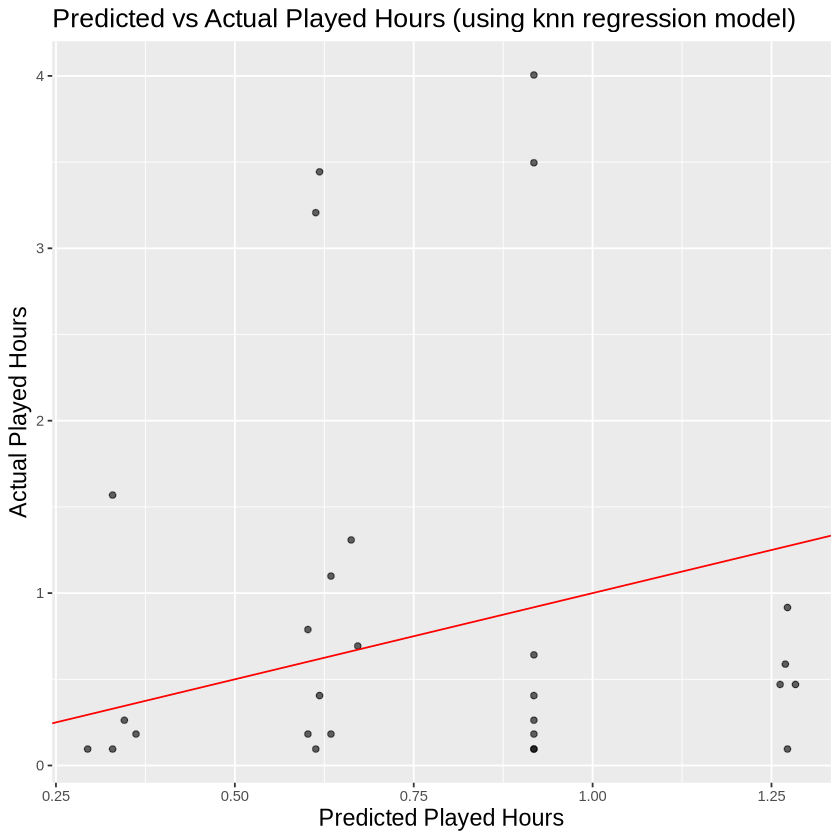

In [40]:
knn_visualization <- ggplot(players_predictions, aes(x = .pred, y = played_hours_log)) +
  geom_point(alpha = 0.6) +
  geom_abline(slope = 1, intercept = 0, color = "red") +
  labs(title = "Predicted vs Actual Played Hours",
       x = "Predicted Played Hours",
       y = "Actual Played Hours")+
    theme(plot.title = element_text(size = 16),
        axis.title = element_text(size = 14))+
        ggtitle("Predicted vs Actual Played Hours (using knn regression model)")
knn_visualization 

#### 2. Attempting a linear regression using the same split used in KNN

In [12]:
# Create model specification + recipe + fit multivariable linear regression model
players_lm_spec <- linear_reg() |>
    set_engine("lm") |>
    set_mode("regression")
players_lm_recipe <- recipe(played_hours_log ~ experience_fct + Age + gender_fct, data = players_training) |>
    step_dummy(all_nominal_predictors())
players_lm_fit <- workflow() |>
    add_recipe(players_lm_recipe) |>
    add_model(players_lm_spec) |>
    fit(data = players_training)
players_lm_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_dummy()

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
                 (Intercept)                           Age  
                     0.79470                      -0.01885  
      experience_fct_Veteran        experience_fct_Amateur  
                    -0.22168                       0.47923  
      experience_fct_Regular       experience_fct_Beginner  
                     1.20575                      -0.04370  
           gender_fct_Female         gender_fct_Non.binary  
                     0.61785                       0.74536  
gender_fct_Prefer.not.to.say            gender_fct_Agender  
                    -0.27035                       2.53852  
     gende

In [38]:
lm_predictions <- players_lm_fit |>
    predict(players_testing) |>
    bind_cols(players_testing)

lm_test_results <- lm_predictions|>
    metrics(truth = played_hours_log, estimate = .pred) |>
    filter(.metric == "rmse")
print(glue("The RMSPE value using a linear regression model is {lm_test_results |> pull(.estimate)}"))

Warning message in predict.lm(object = object$fit, newdata = new_data, type = "response", :
“prediction from rank-deficient fit; consider predict(., rankdeficient="NA")”


The RMSPE value using a linear regression model is 1.28704569140355


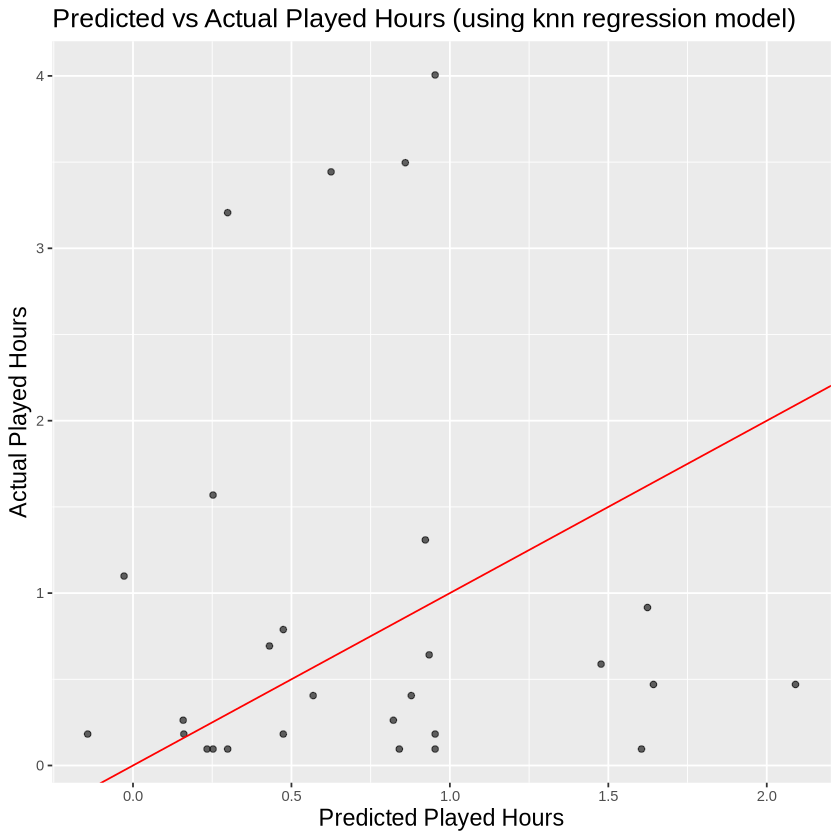

In [41]:
lm_visualization <- ggplot(lm_predictions, aes(x = .pred, y = played_hours_log)) +
  geom_point(alpha = 0.6) +
  geom_abline(slope = 1, intercept = 0, color = "red") +
  labs(title = "Predicted vs Actual Played Hours",
       x = "Predicted Played Hours",
       y = "Actual Played Hours")+
    theme(plot.title = element_text(size = 16),
        axis.title = element_text(size = 14))+
        ggtitle("Predicted vs Actual Played Hours (using knn regression model)")
lm_visualization 

# Conclusion

KNN regression model fits the data better.